## UNIVERSIDADE FEDERAL RURAL DO SEMI-ÁRIDO

## ANÁLISE DE ACIDENTES EM RODOVIAS FEDERAIS DO RN


**Trabalho Desenvolvido Por: Daniel da Silva Santos**

**Caraúbas - 2019**

### Índice
1. [Seleção de Dados](#1.-Sele%C3%A7%C3%A3o-de-Dados)
2. [Pré-processamento](#2.-Pr%C3%A9-processamento)
3. [Exploração](#3.-Explora%C3%A7%C3%A3o)
4. [Transformação](#4.-Transforma%C3%A7%C3%A3o)
5. [Mineração de Padrões Frequentes](#5.-Minera%C3%A7%C3%A3o-de-Padr%C3%B5es-Frequentes)

Abaixo estão as importações de módulos necessários para a análise de dados.

In [1]:
# importações
import pandas as pd, seaborn as sns,matplotlib.pyplot as plt, mlxtend.frequent_patterns, mlxtend.preprocessing, os,warnings

Algumas configurações pouco relevantes para o trabalho.

In [2]:
# ignorar menssagens de warnings
warnings.filterwarnings('ignore')

### 1. Seleção de Dados

O conjunto de dados obtidos no site da PRF se encontram em uma pasta local datatran, o código abaixo encontra esses arquivos.

In [ ]:
# lista de fontes de dados (arquivos .csv)
acidentes_fontes = os.listdir('acidentes')

Devido a razões de desempenho e ao propósito do trabalho, somente alguns atributos (listados abaixo) foram selecionados.

In [ ]:
# somente variáveis consideradas relevantes para o trabalho
colunas_a_estudar = ['id','data_inversa','uf','br','municipio','causa_acidente','tipo_acidente','classificacao_acidente','fase_dia','condicao_metereologica','tipo_pista','uso_solo','tipo_envolvido','idade','sexo']

O código abaixo carrega as fontes de dados e extrai os registros ocorridos no RN de acordo com atributos julgados relevantes.

In [ ]:
# ler cada arquivo de fonte de dados, extrair registros ocorridos no RN e selecionar apenas os atributos de interesse.
acidentes_rn_sep = [pd.read_csv('acidentes/'+df,sep=None,encoding='ansi',usecols=colunas_a_estudar).query('uf=="RN"') for df in acidentes_fontes]

Salvar registros ocorridos no estado do Rio Grande do Norte com os atributos relevantes em uma pasta local *acidentes-rn*

In [ ]:
# salvar registros ocorridos no RN como arquivos .csv
for ano,arquivo in enumerate(acidentes_rn_sep,2007):
    arquivo.to_csv('acidentes-rn/acidentesrn'+str(ano)+'.csv',index=False)

[Voltar ao Índice](#%C3%8Dndice)

### 2. Pré-processamento

Ler arquivos com registros e atributos selecionados na seção [anterior](#1.-Sele%C3%A7%C3%A3o-de-Dados).

In [3]:
acidentes_rn = [pd.read_csv('acidentes-rn/'+df) for df in os.listdir('acidentes-rn')]

Os conjuntos de dados estão separados de acordo com o ano, o código abaixo integra, em um único *Data Frame*, todos os registros. 

In [4]:
# integração de dados
acidentes_rn = pd.concat(acidentes_rn,ignore_index=True)

O comando seguinte exibe os primeiros registros do conjunto de dado integrado.

In [5]:
# observar início do conjunto de dados
acidentes_rn.head()

,id,data_inversa,uf,br,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,condicao_metereologica,tipo_pista,uso_solo,tipo_envolvido,idade,sexo
0,173746.0,01/01/2007,RN,101.0,EXTREMOZ,Falta de atenção,Saída de Pista,Sem Vítimas,Plena noite,Ceu Claro,Simples,Rural,Condutor,40.0,Masculino
1,173937.0,01/01/2007,RN,304.0,MACAIBA,Outras,Colisão com objeto móvel,Com Vítimas Feridas,Plena noite,Ceu Claro,Simples,Rural,Condutor,23.0,Masculino
2,173943.0,01/01/2007,RN,101.0,SAO GONCALO DO AMARANTE,Não guardar distância de segurança,Colisão traseira,Sem Vítimas,Anoitecer,Ceu Claro,Dupla,Urbano,Condutor,-1.0,Masculino
3,173943.0,01/01/2007,RN,101.0,SAO GONCALO DO AMARANTE,Não guardar distância de segurança,Colisão traseira,Sem Vítimas,Anoitecer,Ceu Claro,Dupla,Urbano,Condutor,-1.0,Masculino
4,173965.0,01/01/2007,RN,101.0,PARNAMIRIM,Ingestão de álcool,Colisão traseira,Sem Vítimas,Pleno dia,Ceu Claro,Dupla,Rural,Condutor,32.0,Masculino


Verificar atributos e os tipos desses, presentes na tabela.

In [6]:
# tipos dos atributos
acidentes_rn.dtypes

id                        float64
data_inversa               object
uf                         object
br                        float64
municipio                  object
causa_acidente             object
tipo_acidente              object
classificacao_acidente     object
fase_dia                   object
condicao_metereologica     object
tipo_pista                 object
uso_solo                   object
tipo_envolvido             object
idade                     float64
sexo                       object
dtype: object

A quantidade de registos (linhas) e de atributos (colunas) é obtido como se segue.

In [7]:
# quantidade de registros e de atributos
registros,atributos = acidentes_rn.shape

print('registros: ',registros,' atributos: ',atributos)

registros:  78356  atributos:  15


Verificar em quais atributos há valores nulos (não presentes).

In [8]:
# verificar valores nulos
acidentes_rn.isnull().any()

id                        False
data_inversa              False
uf                        False
br                         True
municipio                 False
causa_acidente            False
tipo_acidente             False
classificacao_acidente    False
fase_dia                  False
condicao_metereologica    False
tipo_pista                False
uso_solo                  False
tipo_envolvido            False
idade                      True
sexo                       True
dtype: bool

É preferível que a coluna *id* presente no conjunto de dados seja tratada como índice, pois essa variável diferencia as ocorrências de acidentes. Para que isso seja realizado, primeiramente essa coluna será considerada um tipo categórico.

In [9]:
# definir o id dos acidentes como um tipo de categoria (str)
acidentes_rn['id'] = acidentes_rn['id'].astype('int32').astype('str')

# verificar resultado
acidentes_rn['id'].dtype

dtype('O')

O comando abaixo seleciona, então, a coluna *id* para ser o *index* da tabela.

In [10]:
# definir coluna 'id' como índice da tabela
acidentes_rn.set_index('id',inplace=True)

# exibir novo índice
acidentes_rn.index

Index(['173746', '173937', '173943', '173943', '173965', '173965', '173965',
       '173991', '173991', '174009',
       ...
       '186997', '187108', '187108', '187108', '187108', '188265', '188265',
       '188460', '188460', '191176'],
      dtype='object', name='id', length=78356)

Ao analisar os atributos, verifica-se que a variável *uf* se torna irrelevante, haja vista que há apenas registros ocorridos no RN agora. O comando abaixo remove essa coluna do conjunto de dados.

In [11]:
# remover coluna 'uf'
acidentes_rn.drop('uf',axis=1,inplace=True)

# verificar colunas da base de dados, percebe-se a ausência da coluna removida.
acidentes_rn.columns

Index(['data_inversa', 'br', 'municipio', 'causa_acidente', 'tipo_acidente',
       'classificacao_acidente', 'fase_dia', 'condicao_metereologica',
       'tipo_pista', 'uso_solo', 'tipo_envolvido', 'idade', 'sexo'],
      dtype='object')

O atributo *data_inversa* é muito importante para uma análise histórica dos acidentes, felizmente, não há valores ausentes nessa coluna, por isso, não se encontra impasse na manipulção desse atributo, contudo, para simplificar ainda mais esse processo, o comando abaixo foi executado, o qual converte os valores cronológicos em objetos facilmente manipuláveis.

In [12]:
# converter coluna 'data_inversa' para um objeto que o pandas manipula facilmente
acidentes_rn['data_inversa']=pd.to_datetime(acidentes_rn['data_inversa'],dayfirst=True)

Agora, extrair informações como dia, mês e ano do acidente se torna fácil a partir da coluna *data_inversa*. 

In [13]:
# dias da semana em que os acidentes ocorreram
dias = acidentes_rn['data_inversa'].dt.day_name(locale='pt').rename('dia')

# meses em que os acidentes ocorreram
meses = acidentes_rn['data_inversa'].dt.month_name(locale='pt').rename('mes')

# anos em que os acidentes ocorreram
anos = acidentes_rn['data_inversa'].dt.year.rename('ano').astype('str')

O código abaixo remove o atributo *data_inversa* (que se torna obsoleto) e insere dias, meses e anos de ocorrência.

In [14]:
# remover coluna 'data_inversa'
acidentes_rn.drop('data_inversa',axis=1,inplace=True)

# inserir colunas dia, mes, ano
acidentes_rn =pd.concat([anos,meses,dias,acidentes_rn],axis=1)

O comando abaixo, novamente, exibe os primeiros registros do *Data Frame* principal, percebe-se a presença das novas colunas.

In [15]:
acidentes_rn.head()

,ano,mes,dia,br,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,condicao_metereologica,tipo_pista,uso_solo,tipo_envolvido,idade,sexo
id,,,,,,,,,,,,,,,
173746,2007,Janeiro,Segunda-feira,101.0,EXTREMOZ,Falta de atenção,Saída de Pista,Sem Vítimas,Plena noite,Ceu Claro,Simples,Rural,Condutor,40.0,Masculino
173937,2007,Janeiro,Segunda-feira,304.0,MACAIBA,Outras,Colisão com objeto móvel,Com Vítimas Feridas,Plena noite,Ceu Claro,Simples,Rural,Condutor,23.0,Masculino
173943,2007,Janeiro,Segunda-feira,101.0,SAO GONCALO DO AMARANTE,Não guardar distância de segurança,Colisão traseira,Sem Vítimas,Anoitecer,Ceu Claro,Dupla,Urbano,Condutor,-1.0,Masculino
173943,2007,Janeiro,Segunda-feira,101.0,SAO GONCALO DO AMARANTE,Não guardar distância de segurança,Colisão traseira,Sem Vítimas,Anoitecer,Ceu Claro,Dupla,Urbano,Condutor,-1.0,Masculino
173965,2007,Janeiro,Segunda-feira,101.0,PARNAMIRIM,Ingestão de álcool,Colisão traseira,Sem Vítimas,Pleno dia,Ceu Claro,Dupla,Rural,Condutor,32.0,Masculino


Alguns registros, por algum motivo, não indicam a BR do estado na qual ocorreu o acidente, isso pode ser um grande problema para análise, felizmente, o número de registros sem essa informação é mínimo - como se pode observar abaixo.

In [16]:
# registros sem informação da br
br_nulos = acidentes_rn[acidentes_rn['br'].isnull()]

# exibir registros
br_nulos

,ano,mes,dia,br,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,condicao_metereologica,tipo_pista,uso_solo,tipo_envolvido,idade,sexo
id,,,,,,,,,,,,,,,
43336,2017,Junho,Domingo,NaN,MOSSORO ...,Defeito na Via ...,Colisão transversal ...,Com Vítimas Feridas,Plena Noite,Céu Claro,Simples,Sim,Condutor,28.0,Masculino
43336,2017,Junho,Domingo,NaN,MOSSORO ...,Defeito na Via ...,Colisão transversal ...,Com Vítimas Feridas,Plena Noite,Céu Claro,Simples,Sim,Testemunha,NaN,Não Informado
43336,2017,Junho,Domingo,NaN,MOSSORO ...,Defeito na Via ...,Colisão transversal ...,Com Vítimas Feridas,Plena Noite,Céu Claro,Simples,Sim,Testemunha,NaN,Não Informado
43336,2017,Junho,Domingo,NaN,MOSSORO ...,Defeito na Via ...,Colisão transversal ...,Com Vítimas Feridas,Plena Noite,Céu Claro,Simples,Sim,Condutor,45.0,Masculino
43336,2017,Junho,Domingo,NaN,MOSSORO ...,Defeito na Via ...,Colisão transversal ...,Com Vítimas Feridas,Plena Noite,Céu Claro,Simples,Sim,Passageiro,37.0,Masculino
43336,2017,Junho,Domingo,NaN,MOSSORO ...,Defeito na Via ...,Colisão transversal ...,Com Vítimas Feridas,Plena Noite,Céu Claro,Simples,Sim,Passageiro,38.0,Masculino
65637,2017,Agosto,Domingo,NaN,MOSSORO ...,Ingestão de Álcool ...,Colisão com objeto em movimento ...,Com Vítimas Feridas,Plena Noite,Céu Claro,Simples,Não,Condutor,NaN,Não Informado
65637,2017,Agosto,Domingo,NaN,MOSSORO ...,Ingestão de Álcool ...,Colisão com objeto em movimento ...,Com Vítimas Feridas,Plena Noite,Céu Claro,Simples,Não,Condutor,31.0,Masculino
78134,2017,Outubro,Sábado,NaN,EXTREMOZ ...,Falta de Atenção à Condução ...,Colisão frontal ...,Com Vítimas Feridas,Pleno dia,Céu Claro,Dupla,Não,Condutor,23.0,Masculino


Como a quantidade de elementos com ausência do atributo *br* é muito pequena, decidiu-se atribuir manualmente esses valores. Obviamente, o melhor recurso disponível na fonte de dados para estimar esses valores ausentes é o atributo dos municípios. Desse modo, os campos faltosos foram preenchidos com o número da *br* com maior quantidade de registros em cada município (moda).

In [17]:
# calcular modas da quantidade de ocorrências em cada município.
br_modas = acidentes_rn['br'].groupby(acidentes_rn['municipio']).agg(pd.Series.mode)

# receber modas dos municípios presentes nos registros com dados faltosos
br_nulos_modas = br_modas[br_nulos['municipio']]

# modificar índice
br_nulos_modas.index = br_nulos.index

# modificar valores
acidentes_rn.loc[br_nulos.index.unique(),'br'] = br_nulos_modas

Pode-se observar que agora não é mais encontrado valores ausentes na coluna *br*.

In [18]:
acidentes_rn.isnull().any()

ano                       False
mes                       False
dia                       False
br                        False
municipio                 False
causa_acidente            False
tipo_acidente             False
classificacao_acidente    False
fase_dia                  False
condicao_metereologica    False
tipo_pista                False
uso_solo                  False
tipo_envolvido            False
idade                      True
sexo                       True
dtype: bool

Deseja-se verficiar quais são as rodovias federais do Rio Grande do Norte presentes nos registros, a seguinte linha realiza isso.

In [19]:
# verificar quais rodovias estão envolvidas nos acidentes
acidentes_rn['br'].unique()

array([101., 304., 226., 110., 406., 405., 427., 343., 501., 268., 104.])

Como se observa, a coluna - número da rodovia - não está bem formatada, pois os valores dessas estão sendo considerados números de ponto flutuante, a seguir, esses valores serão convertidos para tipos categóricos.

In [20]:
# conversão para inteiros e, em seguida, para caracteres
acidentes_rn['br'] = acidentes_rn['br'].astype('int').astype('str')

# observar resultado
acidentes_rn['br'].unique()

array(['101', '304', '226', '110', '406', '405', '427', '343', '501',
       '268', '104'], dtype=object)

Nota-se, ainda sobre a coluna *br*, que há classes inconsistentes, no estado do Rio Grande do Norte estão presentes apenas 9 rodovias federais, não 11, além disso, segundo o DNIT, não existe uma **BR-501** e as **BR-268**, **BR-343** não atravessam o território potiguar.

In [21]:
# registros com valores inconsistentes
br_inconsistentes = acidentes_rn[acidentes_rn['br'].isin(['268','343','501'])]

# exibir esses registros
br_inconsistentes

,ano,mes,dia,br,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,condicao_metereologica,tipo_pista,uso_solo,tipo_envolvido,idade,sexo
id,,,,,,,,,,,,,,,
1121095,2012,Maio,Sábado,343,MOSSORO,Outras,Atropelamento de pessoa,Com Vítimas Feridas,Pleno dia,Sol,Dupla,Urbano,Condutor,36.0,Feminino
1121095,2012,Maio,Sábado,343,MOSSORO,Outras,Atropelamento de pessoa,Com Vítimas Feridas,Pleno dia,Sol,Dupla,Urbano,Passageiro,30.0,Feminino
1121095,2012,Maio,Sábado,343,MOSSORO,Outras,Atropelamento de pessoa,Com Vítimas Feridas,Pleno dia,Sol,Dupla,Urbano,Pedestre,70.0,Masculino
1135692,2012,Julho,Domingo,501,NATAL,Desobediência à sinalização,Colisão Transversal,Sem Vítimas,Plena noite,Nublado,Dupla,Urbano,Condutor,73.0,Masculino
1135692,2012,Julho,Domingo,501,NATAL,Desobediência à sinalização,Colisão Transversal,Sem Vítimas,Plena noite,Nublado,Dupla,Urbano,Condutor,-1.0,Masculino
1337667,2013,Julho,Sábado,268,CEARA-MIRIM,Outras,Colisão frontal,Com Vítimas Feridas,Plena noite,Ceu Claro,Simples,Rural,Condutor,33.0,Masculino
1337667,2013,Julho,Sábado,268,CEARA-MIRIM,Outras,Colisão frontal,Com Vítimas Feridas,Plena noite,Ceu Claro,Simples,Rural,Condutor,-1.0,Masculino


Os valores inconsistentes para o atributo *br* foram tratados como se fossem dados incompletos, isto é nulos, portanto, utilizou-se novamente a moda estatística para estimar esses valores.

In [22]:
# receber modas dos municípios presentes nos registros com dados inconsistentes
br_inconsistentes_modas = br_modas[br_inconsistentes['municipio']]

# modificar index
br_inconsistentes_modas.index = br_inconsistentes.index

# substituir valores inconsistentes
acidentes_rn.loc[br_inconsistentes.index.unique(),'br'] = br_inconsistentes_modas.astype('int').astype('str')

# observar resultado novamente
acidentes_rn['br'].unique()

array(['101', '304', '226', '110', '406', '405', '427', '104'],
      dtype=object)

A variável *idade* é um importante atributo para se montar o perfil das vítimas de acidentes, como visto anteriormente, nessa coluna, alguns valores estão ausentes, o número de registros com esse problema é significativo, por isso, a esses foram atribuidos o valor *-1* para que sejam tratados posteriormente.

In [23]:
# substituir valores núlos por -1
acidentes_rn['idade'].fillna(-1,inplace=True)

# considerar idades como valores inteiros
acidentes_rn['idade'] = acidentes_rn['idade'].astype('int')

# exibir quantidade de registros nulos
acidentes_rn[acidentes_rn['idade']==-1].shape[0]

11524

O bloco a seguir revela quais os valores assumidos pelas idades das vítimas, observa-se valores ruidosos como idades muito acima de 100 anos, esses valores foram tratados como nulos (maiores que 110 anos).

In [24]:
# observar valores de idades
acidentes_rn['idade'].unique()

array([  40,   23,   -1,   32,   24,   28,   42,   33,   26,   21,   55,
         20,   71,   49,   41,   46,   58,   63,   51,   15,   17,   44,
         25,   35,   45,   34,   68,   31,   27,   66,   47,   14,   19,
         48,   50,   43,   22,   29,   64,   30,   38,   36,   52,   37,
         53,   70,   54,   59,   65,   39,   56,   57,    5,   60,   61,
         18,    0,   13,   69,   62,   67,   16,   77,   76,   10,   11,
         12,   75,    9,   80,   81,    2,   90,   86,    6,    3,   74,
         78,   72,    7,    4,   73,   79,   88,    1,    8,   84,   82,
         87,   91,   83,  109,   94,   85,  125,   89,  111,  127,  106,
         95,  128,  906, 1916,  117,  939], dtype=int64)

In [25]:
# modificar valores de idades maiores que 110 anos para -1 (valor desconhecido)
acidentes_rn.loc[acidentes_rn['idade']>=110,'idade'] = -1

# observar resultado
acidentes_rn['idade'].unique()

array([ 40,  23,  -1,  32,  24,  28,  42,  33,  26,  21,  55,  20,  71,
        49,  41,  46,  58,  63,  51,  15,  17,  44,  25,  35,  45,  34,
        68,  31,  27,  66,  47,  14,  19,  48,  50,  43,  22,  29,  64,
        30,  38,  36,  52,  37,  53,  70,  54,  59,  65,  39,  56,  57,
         5,  60,  61,  18,   0,  13,  69,  62,  67,  16,  77,  76,  10,
        11,  12,  75,   9,  80,  81,   2,  90,  86,   6,   3,  74,  78,
        72,   7,   4,  73,  79,  88,   1,   8,  84,  82,  87,  91,  83,
       109,  94,  85,  89, 106,  95], dtype=int64)

O sexo é mais um atributo relevante relativo ao estudo do perfil dos acidentados. Com há valores nulos presentes nessa coluna também, um tratamento semelhante ao das idades será realizado, os valores nulos serão categorizados como **IGNORADO**, dessa maneira esses dados serão tratados posteriormente com mais facilidade.

In [26]:
# considerar valores nulos como Ignorado
acidentes_rn['sexo'].fillna('Ignorado',inplace=True)

O bloco abaixo é responsável por exibir os valores presentes na coluna *sexo*. Como esperado, essa coluna também possui uma má formatação, exemplo, alguns valores são categorizados como **Masculino** ou **Feminino**, outros pelas letras **F** e **M**, ademais, algumas categorias estão com espaços em brancos o que causa distinção mesmo de items iguais, todos esses problemas serão resolvidos em seguida. 

In [27]:
# valores da coluna sexo
acidentes_rn['sexo'].unique()

array(['Masculino', 'Não Informado', 'Feminino', 'Ignorado', 'Inválido',
       'M', 'F', 'I', 'Masculino           ', 'Feminino            ',
       'Não Informado       ', 'Ignorado            '], dtype=object)

Os valores **Não Informado**, **I** e **Inválido** serão genericamente considerados **Ignorado**.

In [28]:
# padronizar caracteres dos atributos
acidentes_rn.loc[:,'sexo'] = acidentes_rn.loc[:,'sexo'].map(str.title).map(str.strip)

# considerar M como Masculino e F como feminino
acidentes_rn['sexo'].replace(['M','F'],['Masculino','Feminino'],inplace=True)

# considerar não informado, I e inválido como Ignorado
acidentes_rn['sexo'].replace(['Não Informado','I','Inválido'],'Ignorado',inplace=True)

O seguinte bloco verifica se os problemas relacionados a coluna *sexo* foram corrigidos.

In [29]:
acidentes_rn['sexo'].unique()

array(['Masculino', 'Ignorado', 'Feminino'], dtype=object)

Para padronizar os caracteres dos demais atributos, a linha abaixo foi executada, como antes, isso evita erros.

In [30]:
# padronizar todos os atributos exceto os já tratados ano,mes,dia,br,idade,sexo
acidentes_rn.loc[:,'municipio':'tipo_envolvido'] = acidentes_rn.loc[:,'municipio':'tipo_envolvido'].applymap(str.title).applymap(str.strip)

Verificar tipo de envolvidos em acidentes.

In [31]:
# exibir valores que a varíavel 'tipo_envolvido' assume
acidentes_rn['tipo_envolvido'].sort_values().unique()

array(['Cavaleiro', 'Ciclista', 'Condutor', 'Passageiro', 'Pedestre',
       'Testemunha', 'Vítima'], dtype=object)

Verificar municípios presentes nos registros.

In [32]:
# exibir municípios para verificar se estão padronizados
acidentes_rn['municipio'].sort_values().unique()

array(['Acari', 'Acu', 'Almino Afonso', 'Angicos', 'Antonio Martins',
       'Apodi', 'Areia Branca', 'Ares', 'Assu', 'Augusto Severo',
       'Baia Formosa', 'Bom Jesus', 'Caicara Do Norte',
       'Caicara Do Rio Do Vento', 'Caico', 'Campo Grande',
       'Campo Redondo', 'Canguaretama', 'Ceara-Mirim', 'Currais Novos',
       'Extremoz', 'Felipe Guerra', 'Fernando Pedroza', 'Florania',
       'Goianinha', 'Governador Dix-Sept Rosado', 'Guamare',
       'Ielmo Marinho', 'Ipanguacu', 'Itaja', 'Itau', 'Jandaira',
       'Janduis', 'Jardim Do Serido', 'Joao Camara', 'Jose Da Penha',
       'Jucurutu', 'Lajes', 'Lajes Pintadas', 'Luis Gomes', 'Macaiba',
       'Macau', 'Major Sales', 'Marcelino Vieira', 'Martins',
       'Maxaranguape', 'Messias Targino', 'Mossoro', 'Natal',
       'Nisia Floresta', 'Parau', 'Parnamirim', 'Patu', 'Pau Dos Ferros',
       'Pedro Avelino', 'Poco Branco', 'Rafael Fernandes',
       'Riacho De Santana', 'Riachuelo', 'Rio Do Fogo',
       'Rodolfo Fernandes', 

Verificar as causas de acidentes atribuidas as ocorrências.

In [33]:
# exibir as causas de acidentes compiladas a partir dos dados
acidentes_rn['causa_acidente'].sort_values().unique()

array(['Agressão Externa', 'Animais Na Pista',
       'Avarias E/Ou Desgaste Excessivo No Pneu',
       'Carga Excessiva E/Ou Mal Acondicionada', 'Condutor Dormindo',
       'Defeito Mecânico Em Veículo', 'Defeito Mecânico No Veículo',
       'Defeito Na Via',
       'Deficiência Ou Não Acionamento Do Sistema De Iluminação/Sinalização Do Veículo',
       'Desobediência À Sinalização',
       'Desobediência Às Normas De Trânsito Pelo Condutor',
       'Desobediência Às Normas De Trânsito Pelo Pedestre', 'Dormindo',
       'Falta De Atenção', 'Falta De Atenção Do Pedestre',
       'Falta De Atenção À Condução', 'Fenômenos Da Natureza',
       'Ingestão De Substâncias Psicoativas', 'Ingestão De Álcool',
       'Ingestão De Álcool E/Ou Substâncias Psicoativas Pelo Pedestre',
       'Mal Súbito', 'Não Guardar Distância De Segurança',
       'Objeto Estático Sobre O Leito Carroçável', 'Outras',
       'Pista Escorregadia', 'Restrição De Visibilidade',
       'Sinalização Da Via Insuficiente 

Devido a alteração do sistema de coleta de dados, muitos valores para as causas de acidentes estão presentes apenas no conjunto dos dois últimos anos, outros refletem a mesma informação, para a resolução desse problema, muitos valores foram substituidos.

In [34]:
# substiuição de valores redundantes
acidentes_rn.replace({'Defeito Mecânico No Veículo':'Defeito Mecânico Em Veículo',
                      'Avarias E/Ou Desgaste Excessivo No Pneu':'Defeito Mecânico Em Veículo',
                      'Condutor Dormindo':'Dormindo',
                      'Falta De Atenção Do Pedestre':'Falta De Atenção',
                      'Falta De Atenção À Condução':'Falta De Atenção',
                      'Desobediência À Sinalização':'Desobediência Às Normas De Trânsito',
                      'Desobediência Às Normas De Trânsito Pelo Condutor':'Desobediência Às Normas De Trânsito',
                      'Desobediência Às Normas De Trânsito Pelo Pedestre': 'Desobediência Às Normas De Trânsito',
                      'Ingestão De Substâncias Psicoativas': 'Ingestão De Álcool E/Ou Substâncias Psicoativas',
                      'Ingestão De Álcool E/Ou Substâncias Psicoativas Pelo Pedestre': 'Ingestão De Álcool E/Ou Substâncias Psicoativas',
                      'Ingestão De Álcool': 'Ingestão De Álcool E/Ou Substâncias Psicoativas'
                       }, inplace=True)

# valores imcompatíveis serão considerados genericamente 'outras' causas.
acidentes_rn.replace(['Agressão Externa',
                      'Carga Excessiva E/Ou Mal Acondicionada',
                      'Defeito Na Via',
                      'Deficiência Ou Não Acionamento Do Sistema De Iluminação/Sinalização Do Veículo',
                      'Fenômenos Da Natureza',
                      'Mal Súbito',
                      'Objeto Estático Sobre O Leito Carroçável',
                      'Pista Escorregadia',
                      'Restrição De Visibilidade',
                      'Sinalização Da Via Insuficiente Ou Inadequada'
                      ],'Outras', inplace=True)
# exibir novos valores
acidentes_rn['causa_acidente'].sort_values().unique()

array(['Animais Na Pista', 'Defeito Mecânico Em Veículo',
       'Desobediência Às Normas De Trânsito', 'Dormindo',
       'Falta De Atenção',
       'Ingestão De Álcool E/Ou Substâncias Psicoativas',
       'Não Guardar Distância De Segurança', 'Outras',
       'Ultrapassagem Indevida', 'Velocidade Incompatível'], dtype=object)

Observar os tipos de acidentes ocorridos.

In [35]:
# exibir os tipos de acidentes
acidentes_rn['tipo_acidente'].sort_values().unique()

array(['Atropelamento De Animal', 'Atropelamento De Pedestre',
       'Atropelamento De Pessoa', 'Capotamento', 'Colisão Com Bicicleta',
       'Colisão Com Objeto Em Movimento', 'Colisão Com Objeto Estático',
       'Colisão Com Objeto Fixo', 'Colisão Com Objeto Móvel',
       'Colisão Frontal', 'Colisão Lateral', 'Colisão Transversal',
       'Colisão Traseira', 'Danos Eventuais', 'Derramamento De Carga',
       'Engavetamento', 'Incêndio',
       'Queda De Motocicleta / Bicicleta / Veículo',
       'Queda De Ocupante De Veículo', 'Saída De Leito Carroçável',
       'Saída De Pista', 'Tombamento'], dtype=object)

Percebe-se que há redundâncias entre os valores dos tipos de acidentes, o bloco abaixo resolve esse problema.

In [36]:
# corrigir redundâncias
acidentes_rn['tipo_acidente'].replace(['Atropelamento De Pedestre',
                                       'Colisão Com Objeto Estático',
                                       'Colisão Com Objeto Em Movimento',
                                       'Queda De Motocicleta / Bicicleta / Veículo',
                                       'Saída De Leito Carroçável'
                                      ],['Atropelamento De Pessoa',
                                         'Colisão Com Objeto Fixo',
                                         'Colisão Com Objeto Móvel',
                                         'Queda De Ocupante De Veículo',
                                         'Saída De Pista'],inplace=True)

acidentes_rn['tipo_acidente'].sort_values().sort_values().unique()

array(['Atropelamento De Animal', 'Atropelamento De Pessoa',
       'Capotamento', 'Colisão Com Bicicleta', 'Colisão Com Objeto Fixo',
       'Colisão Com Objeto Móvel', 'Colisão Frontal', 'Colisão Lateral',
       'Colisão Transversal', 'Colisão Traseira', 'Danos Eventuais',
       'Derramamento De Carga', 'Engavetamento', 'Incêndio',
       'Queda De Ocupante De Veículo', 'Saída De Pista', 'Tombamento'],
      dtype=object)

Observar as classificações atribuidas aos acidentes.

In [37]:
# exibir classificações dos acidentes
acidentes_rn['classificacao_acidente'].sort_values().unique()

array(['Com Vítimas Fatais', 'Com Vítimas Feridas', 'Ignorado',
       'Sem Vítimas'], dtype=object)

Horários categóricos nos quais os acidentes ocorreram.

In [38]:
# exibir as fases do dias
acidentes_rn['fase_dia'].sort_values().unique()

array(['(Null)', 'Amanhecer', 'Anoitecer', 'Plena Noite', 'Pleno Dia'],
      dtype=object)

Percebe-se que mesmo não detectado anteriormente, a coluna *fase_dia* possui valores nulos, provavelmente isso ocorreu pois esses dados foram considerados cadeias de caracteres. Pode-se observar que somente um registro de acidente possui esse atrbuto nulo, além disso, na fonte de dados original há o horário exato em que o acidente ocorreu (**14:50 h**), dessa maneira é fácil a esse elemento atribuir um valor manualmente como **PLENO DIA**.

In [39]:
# definir valor com fase de dia nulo como 'Pleno Dia'
acidentes_rn.loc[acidentes_rn['fase_dia']=='(Null)','fase_dia'] = 'Pleno Dia'

# observar o resultado
acidentes_rn['fase_dia'].sort_values().unique()

array(['Amanhecer', 'Anoitecer', 'Plena Noite', 'Pleno Dia'], dtype=object)

Observar as condicões metereológicas sobre as quais os acidentes ocorreram

In [40]:
# exibir condições metereológicas dos acidentes
acidentes_rn['condicao_metereologica'].sort_values().unique()

array(['(Null)', 'Ceu Claro', 'Chuva', 'Céu Claro', 'Garoa/Chuvisco',
       'Granizo', 'Ignorada', 'Ignorado', 'Nevoeiro/Neblina', 'Nublado',
       'Sol', 'Vento'], dtype=object)

O mesmo problema se apresenta novamente, há valores ausentes no atributo considerado, além disso, houve acidentes que ocorreram sob a codição metereológica **GRANIZO**, considerando o clima do estado do RN é possível considerar as ocorrências dessa classe como dados ruidosos. O comando abaixo exibe os registros com essas classificações, como se pode observar apenas quatro foram encontradas, como é um grupo muito pequeno, foi atribuida manualmente a essas linhas a classificação **IGNORADO**.

In [41]:
# exibir linhas com condição metereológica nula ou granizo
acidentes_rn[acidentes_rn['condicao_metereologica'].isin(['(Null)','Granizo'])]

,ano,mes,dia,br,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,condicao_metereologica,tipo_pista,uso_solo,tipo_envolvido,idade,sexo
id,,,,,,,,,,,,,,,
83224358,2014,Julho,Segunda-feira,226,Currais Novos,Outras,Atropelamento De Pessoa,Com Vítimas Feridas,Pleno Dia,Granizo,Dupla,Urbano,Condutor,19,Feminino
83224358,2014,Julho,Segunda-feira,226,Currais Novos,Outras,Atropelamento De Pessoa,Com Vítimas Feridas,Pleno Dia,Granizo,Dupla,Urbano,Pedestre,64,Feminino
83402950,2015,Outubro,Quarta-feira,110,Mossoro,Outras,Queda De Ocupante De Veículo,Com Vítimas Feridas,Plena Noite,(Null),Dupla,Urbano,Condutor,47,Masculino
83402950,2015,Outubro,Quarta-feira,110,Mossoro,Outras,Queda De Ocupante De Veículo,Com Vítimas Feridas,Plena Noite,(Null),Dupla,Urbano,Passageiro,38,Masculino


In [42]:
# atribuir classe 'Ignorado' a esses registros
acidentes_rn.loc[acidentes_rn['condicao_metereologica'].isin(['(Null)','Granizo']),'condicao_metereologica'] = 'Ignorado'

Percebe-se, ainda, que há outros problemas no atributo de condição metereológica, os valores **CEU CLARO** e **CÉU CLARO** são considerados distintos somente devido ao acento, além disso, existe também um classe **IGNORADA** e redundâncias entre valores, a linha a seguir resolve essa situação.

In [43]:
# trocar valores problemáticos
acidentes_rn['condicao_metereologica'].replace({'Ceu Claro':'Céu Claro',
                                                'Garoa/Chuvisco':'Chuva',
                                                'Ignorada':'Ignorado',
                                                'Nevoeiro/Neblina':'Nublado'},inplace=True)

# verificar se os problemas foram corrigidos
acidentes_rn['condicao_metereologica'].sort_values().unique()

array(['Chuva', 'Céu Claro', 'Ignorado', 'Nublado', 'Sol', 'Vento'],
      dtype=object)

Examinar os tipos de pistas

In [44]:
acidentes_rn['tipo_pista'].unique()

array(['Simples', 'Dupla', 'Múltipla'], dtype=object)

O atributo **uso_solo** indica se o acidente ocorreu com solo **URBANO** ou **RURAL**, alguns registros possuem o valor **SIM** para indicar se o acidente ocorreu em solo urbano e, logicamente, **NÃO**, para o rural. Os próximos comandos exibe isso e em seguida padroniza esses dados.

In [45]:
# exibir valores possíveis
acidentes_rn['uso_solo'].unique()

array(['Rural', 'Urbano', 'Não', 'Sim'], dtype=object)

In [46]:
# padronizar valores
acidentes_rn['uso_solo'].replace(['Sim','Não'],['Urbano','Rural'],inplace=True)

# exibir resultado
acidentes_rn['uso_solo'].unique()

array(['Rural', 'Urbano'], dtype=object)

O próximo código exibe novamente os primeiros registros presentes no *Data Frame*, agora processado.

In [47]:
# exibir linhas iniciais de registros após todo processamento
acidentes_rn.head()

,ano,mes,dia,br,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,condicao_metereologica,tipo_pista,uso_solo,tipo_envolvido,idade,sexo
id,,,,,,,,,,,,,,,
173746,2007,Janeiro,Segunda-feira,101,Extremoz,Falta De Atenção,Saída De Pista,Sem Vítimas,Plena Noite,Céu Claro,Simples,Rural,Condutor,40,Masculino
173937,2007,Janeiro,Segunda-feira,304,Macaiba,Outras,Colisão Com Objeto Móvel,Com Vítimas Feridas,Plena Noite,Céu Claro,Simples,Rural,Condutor,23,Masculino
173943,2007,Janeiro,Segunda-feira,101,Sao Goncalo Do Amarante,Não Guardar Distância De Segurança,Colisão Traseira,Sem Vítimas,Anoitecer,Céu Claro,Dupla,Urbano,Condutor,-1,Masculino
173943,2007,Janeiro,Segunda-feira,101,Sao Goncalo Do Amarante,Não Guardar Distância De Segurança,Colisão Traseira,Sem Vítimas,Anoitecer,Céu Claro,Dupla,Urbano,Condutor,-1,Masculino
173965,2007,Janeiro,Segunda-feira,101,Parnamirim,Ingestão De Álcool E/Ou Substâncias Psicoativas,Colisão Traseira,Sem Vítimas,Pleno Dia,Céu Claro,Dupla,Rural,Condutor,32,Masculino


Para salvar esse conjunto de dados processado, o bloco abaixo foi executado, um arquivo 'datatran-rn.csv' será criado.

In [48]:
# salvar conjunto de dados processados como um arquivo .csv
acidentes_rn.to_csv('acidentes-rn.csv')

### 3. Exploração

O arquivo *acidentes_rn.csv* contém os dados devidamente processados, procedimento realizado na seção de [pré-processamento](#2.-Pr%C3%A9-processamento).

In [49]:
# ler arquivo com dados processados
acidentes_rn = pd.read_csv('acidentes-rn.csv',index_col='id')

Exibir primeiros registros da fonte de dados pré-processado.

In [50]:
# exibir primeiros resultados
acidentes_rn.head()

,ano,mes,dia,br,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,condicao_metereologica,tipo_pista,uso_solo,tipo_envolvido,idade,sexo
id,,,,,,,,,,,,,,,
173746,2007,Janeiro,Segunda-feira,101,Extremoz,Falta De Atenção,Saída De Pista,Sem Vítimas,Plena Noite,Céu Claro,Simples,Rural,Condutor,40,Masculino
173937,2007,Janeiro,Segunda-feira,304,Macaiba,Outras,Colisão Com Objeto Móvel,Com Vítimas Feridas,Plena Noite,Céu Claro,Simples,Rural,Condutor,23,Masculino
173943,2007,Janeiro,Segunda-feira,101,Sao Goncalo Do Amarante,Não Guardar Distância De Segurança,Colisão Traseira,Sem Vítimas,Anoitecer,Céu Claro,Dupla,Urbano,Condutor,-1,Masculino
173943,2007,Janeiro,Segunda-feira,101,Sao Goncalo Do Amarante,Não Guardar Distância De Segurança,Colisão Traseira,Sem Vítimas,Anoitecer,Céu Claro,Dupla,Urbano,Condutor,-1,Masculino
173965,2007,Janeiro,Segunda-feira,101,Parnamirim,Ingestão De Álcool E/Ou Substâncias Psicoativas,Colisão Traseira,Sem Vítimas,Pleno Dia,Céu Claro,Dupla,Rural,Condutor,32,Masculino


O bloco abaixo extrai somente as ocorrências, não considerando dados das vítimas.

In [51]:
# extrair ocorrências
ocorrencias = acidentes_rn.groupby(level=0).first().drop(['idade','sexo','tipo_envolvido'],axis=1)

Quantidade numérica de acidentes ocorridos em todo o RN em cada ano a partir de 2007.

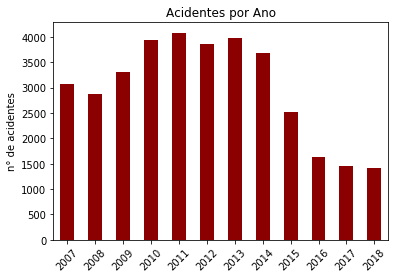

In [52]:
# plotar gráfico de barras
ocorrencias['ano'].value_counts().sort_index().plot(kind='bar',color='darkred',title='Acidentes por Ano',rot='45').set(ylabel='n° de acidentes');

Mapa de calor com a quantidade de acidentes registrados ocorridos em cada mês de cada ano

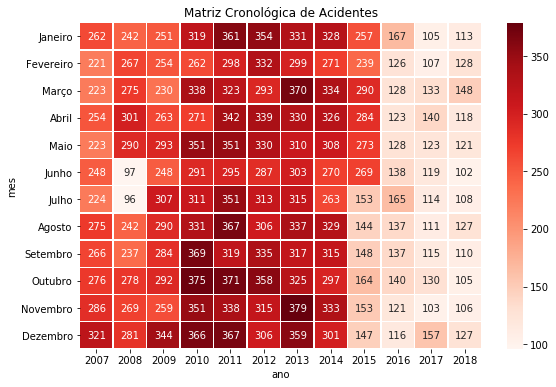

In [53]:
# construir tabela
acidentes_ano_mes = pd.crosstab(ocorrencias['mes'].astype(pd.CategoricalDtype(ocorrencias['mes'].unique(),ordered=True)),ocorrencias['ano'])

# construir figura
f, ax = plt.subplots(figsize=(9, 6))

# título
ax.set_title('Matriz Cronológica de Acidentes')

# plotar mapa de calor
sns.heatmap(acidentes_ano_mes, annot=True, fmt="d", linewidths=.5, ax=ax,cmap='Reds');

Construir um gráficos de setores que indicam como os acidentes estão distribuidos em relação aos dias da semana e aos meses.

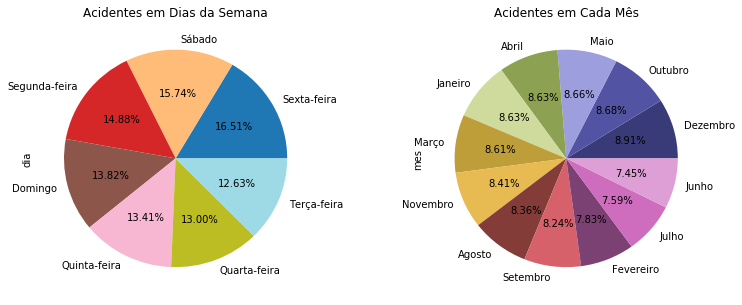

In [54]:
# construir figura
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,5))

# plotagem do gráfico pizza para dias
ocorrencias['dia'].value_counts().plot(kind='pie',title='Acidentes em Dias da Semana',autopct='%.2f%%',colormap='tab20',ax=axes[0]);

# plotagem do gráfico pizza para meses
ocorrencias['mes'].value_counts().plot(kind='pie',title='Acidentes em Cada Mês',autopct='%.2f%%',colormap='tab20b',ax=axes[1]);

fig.subplots_adjust(wspace=0.4)

Explorar ocorrências por municípios e rodovias.

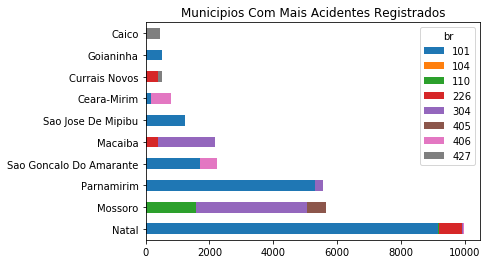

In [55]:
# municipios com maior número de ocorrências registradas
municipios_acidentes = ocorrencias['municipio'].value_counts().head(10)

# realizar plotagem
pd.crosstab(ocorrencias['municipio'],ocorrencias['br']).loc[municipios_acidentes.index].plot(kind='barh',stacked=True,title='Municipios Com Mais Acidentes Registrados');

Observar as causas de acidentes mais importantes e tipos de acidentes mais frequentes.

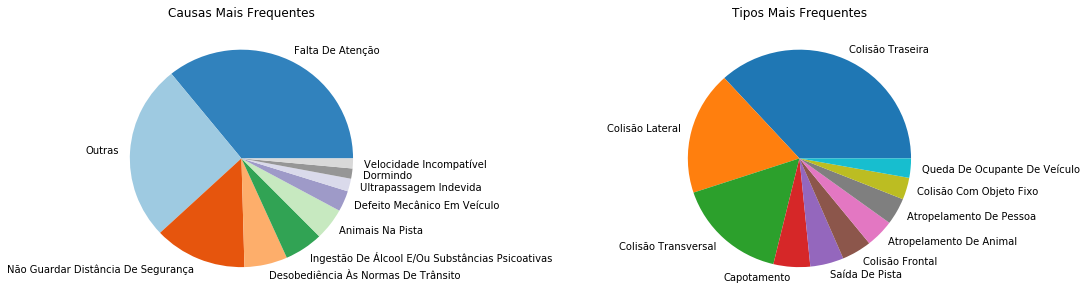

In [56]:
# construir figura
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))

# plotar gráfico de setores com as 10 causas mais frequentes
ocorrencias['causa_acidente'].value_counts().head(10).rename('').plot(kind='pie',colormap='tab20c',title='Causas Mais Frequentes',ax=axes[0]);

# plotar gráfico de setores com os tipos de acidentes mais frequentes
ocorrencias['tipo_acidente'].value_counts().head(10).rename('').plot(kind='pie',colormap='tab10',title='Tipos Mais Frequentes',ax=axes[1]);

# ajustar plotagens
fig.subplots_adjust(wspace=1)

Estudar a relação entre as causas e a classificação quando houve vítimas.

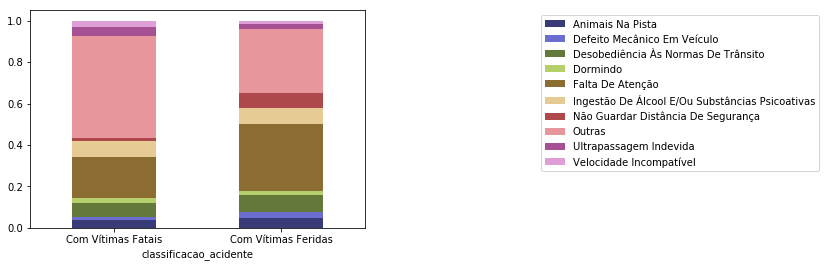

In [57]:
# plotar gráfico normalizado
ax = pd.crosstab(ocorrencias['classificacao_acidente'],ocorrencias['causa_acidente']).apply(lambda r: r/r.sum(), axis=1).iloc[0:2].plot(kind='bar',rot=360,stacked=True,colormap='tab20b');
ax.legend(bbox_to_anchor = (1.51, 1));

Estudar a relação entre os tipos e a classificação quando houve vítimas.

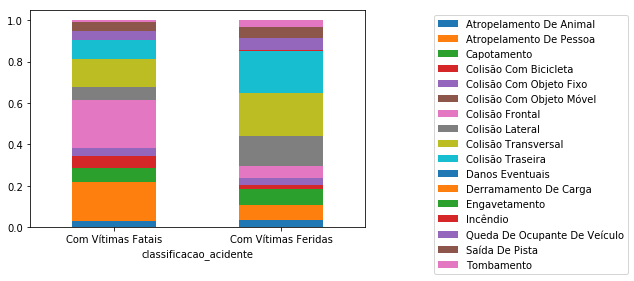

In [58]:
ax = pd.crosstab(ocorrencias['classificacao_acidente'],ocorrencias['tipo_acidente']).apply(lambda r: r/r.sum(), axis=1).iloc[0:2].plot(kind='bar',rot=360,stacked=True);
ax.legend(bbox_to_anchor = (1.80, 1));

Comportamento cronológico das classificações dos acidentes.

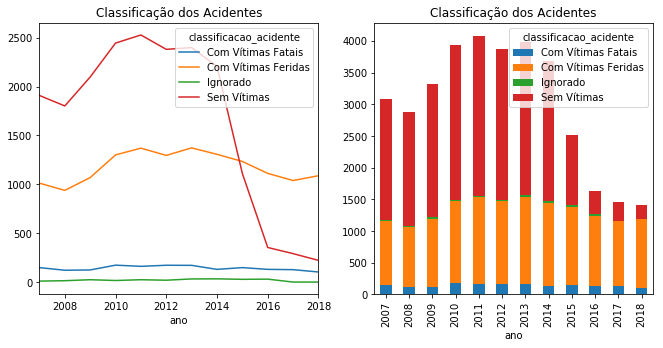

In [59]:
# construir figura
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(11,5))

# plotagem de gráfico linear
pd.crosstab(ocorrencias['ano'],ocorrencias['classificacao_acidente']).plot(kind='line',title='Classificação dos Acidentes',ax=axes[0]);

# plotagem de gráfico de barras
pd.crosstab(ocorrencias['ano'],ocorrencias['classificacao_acidente']).plot(kind='bar',title='Classificação dos Acidentes',stacked=True,ax=axes[1]);

Distribuição de idades das vítimas.

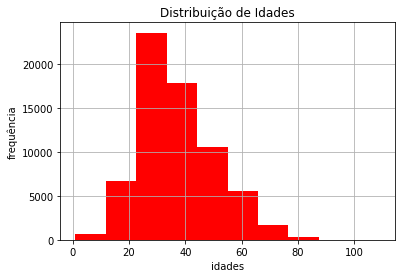

In [60]:
acidentes_rn[acidentes_rn['idade']>0]['idade'].plot(kind='hist',title='Distribuição de Idades',grid=True,color='red').set(xlabel='idades',ylabel='frequência');

Sexo das vítimas.

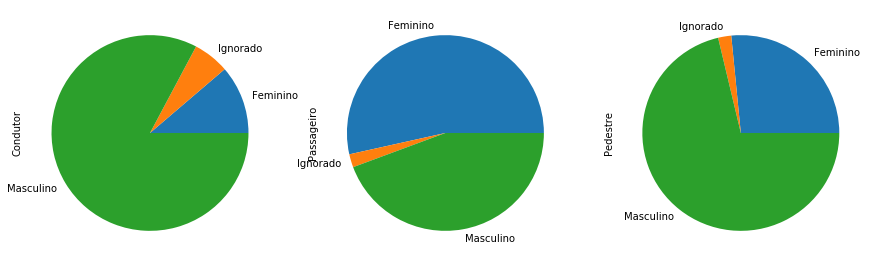

In [61]:
pd.crosstab(acidentes_rn['sexo'],acidentes_rn['tipo_envolvido'])[['Condutor','Passageiro','Pedestre']].plot(kind='pie',subplots=True,figsize=(15,4.5),legend=False);

### 4. Transformação

O arquivo *acidentes-rn.csv* contém os dados devidamente processados, procedimento realizado na seção de [pré-processamento](#2.-Pr%C3%A9-processamento).

In [62]:
# ler arquivo com dados processados
acidentes_rn = pd.read_csv('acidentes-rn.csv')

Exibir primeiros registros do conjunto de dados.

O ano da ocorrência e sua identificação não serão mais úteis, a linha a seguir remove essas prpriedades do conjunto de dados.

In [63]:
# remover colunas 'id' e 'ano'
acidentes_rn.drop(['id','ano'],axis=1,inplace=True)

In [64]:
acidentes_rn = acidentes_rn[acidentes_rn['classificacao_acidente'] != 'Ignorado']
acidentes_rn = acidentes_rn[acidentes_rn['condicao_metereologica'] != 'Ignorado']
acidentes_rn = acidentes_rn[acidentes_rn['sexo'] != 'Ignorado']

In [65]:
acidentes_rn.head()

,mes,dia,br,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,condicao_metereologica,tipo_pista,uso_solo,tipo_envolvido,idade,sexo
0,Janeiro,Segunda-feira,101,Extremoz,Falta De Atenção,Saída De Pista,Sem Vítimas,Plena Noite,Céu Claro,Simples,Rural,Condutor,40,Masculino
1,Janeiro,Segunda-feira,304,Macaiba,Outras,Colisão Com Objeto Móvel,Com Vítimas Feridas,Plena Noite,Céu Claro,Simples,Rural,Condutor,23,Masculino
2,Janeiro,Segunda-feira,101,Sao Goncalo Do Amarante,Não Guardar Distância De Segurança,Colisão Traseira,Sem Vítimas,Anoitecer,Céu Claro,Dupla,Urbano,Condutor,-1,Masculino
3,Janeiro,Segunda-feira,101,Sao Goncalo Do Amarante,Não Guardar Distância De Segurança,Colisão Traseira,Sem Vítimas,Anoitecer,Céu Claro,Dupla,Urbano,Condutor,-1,Masculino
4,Janeiro,Segunda-feira,101,Parnamirim,Ingestão De Álcool E/Ou Substâncias Psicoativas,Colisão Traseira,Sem Vítimas,Pleno Dia,Céu Claro,Dupla,Rural,Condutor,32,Masculino


In [66]:
acidentes_rn = acidentes_rn[acidentes_rn['idade']!=-1]

In [67]:
acidentes_rn.loc[:,'idade'] = pd.cut(acidentes_rn['idade'].astype('int'),6,labels=[
                                                     'criança ou adolescente de até 17 anos',
                                                     'jovem adulto entre 18 e 35 anos',
                                                     'adulto entre 35 e 53 anos',
                                                     'pessoa de idade avançada entre 53 a 70 anos',
                                                     'idoso entre 70 e 88 anos',
                                                     'idoso de idade avançada com mais de 88 anos'])

In [68]:
acidentes_rn.loc[:,'br'] = acidentes_rn['br'].map(lambda br: 'BR '+str(br))

In [69]:
acidentes_rn.drop_duplicates(inplace=True)

In [70]:
acidentes_rn.shape

(52284, 14)

In [71]:
for c in acidentes_rn.columns:
    print(c)
    print(acidentes_rn[c].sort_values().unique())
    print('\n\n')

mes
['Abril' 'Agosto' 'Dezembro' 'Fevereiro' 'Janeiro' 'Julho' 'Junho' 'Maio'
 'Março' 'Novembro' 'Outubro' 'Setembro']



dia
['Domingo' 'Quarta-feira' 'Quinta-feira' 'Segunda-feira' 'Sexta-feira'
 'Sábado' 'Terça-feira']



br
['BR 101' 'BR 104' 'BR 110' 'BR 226' 'BR 304' 'BR 405' 'BR 406' 'BR 427']



municipio
['Acari' 'Acu' 'Almino Afonso' 'Angicos' 'Antonio Martins' 'Apodi'
 'Areia Branca' 'Ares' 'Assu' 'Augusto Severo' 'Baia Formosa' 'Bom Jesus'
 'Caicara Do Rio Do Vento' 'Caico' 'Campo Grande' 'Campo Redondo'
 'Canguaretama' 'Ceara-Mirim' 'Currais Novos' 'Extremoz' 'Felipe Guerra'
 'Fernando Pedroza' 'Florania' 'Goianinha' 'Governador Dix-Sept Rosado'
 'Guamare' 'Ielmo Marinho' 'Ipanguacu' 'Itaja' 'Itau' 'Jandaira' 'Janduis'
 'Jardim Do Serido' 'Joao Camara' 'Jose Da Penha' 'Jucurutu' 'Lajes'
 'Lajes Pintadas' 'Luis Gomes' 'Macaiba' 'Macau' 'Major Sales'
 'Marcelino Vieira' 'Martins' 'Maxaranguape' 'Messias Targino' 'Mossoro'
 'Natal' 'Nisia Floresta' 'Parau' 'Parnamirim' 'Patu

In [72]:
# salvar conjunto de dados transformado como um arquivo .csv
acidentes_rn.to_csv('acidentes-rn-transformado.csv',index=False)

### 5. Mineração de Padrões Frequentes

In [191]:
# ler arquivo com dados transformados
acidentes_rn = pd.read_csv('acidentes-rn-transformado.csv')

In [192]:
te = mlxtend.preprocessing.TransactionEncoder()

transformacao = te.fit(acidentes_rn.values).transform(acidentes_rn.values)

In [193]:
datatran_rn_transformado = pd.DataFrame(transformacao,columns=te.columns_)

In [194]:
itemsets_frequentes = mlxtend.frequent_patterns.apriori(datatran_rn_transformado, min_support=0.1, use_colnames=True)

In [195]:
itemsets_frequentes.head(10)

,support,itemsets
0,0.514574,(BR 101)
1,0.218805,(BR 304)
2,0.179481,(Colisão Lateral)
3,0.175694,(Colisão Transversal)
4,0.347429,(Colisão Traseira)
5,0.440230,(Com Vítimas Feridas)
6,0.865313,(Condutor)
7,0.662880,(Céu Claro)
8,0.145130,(Domingo)
9,0.425006,(Dupla)


In [200]:
regras = mlxtend.frequent_patterns.association_rules(itemsets_frequentes, metric="confidence", min_threshold=.9)

In [201]:
regras[regras['lift']>2]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
45,(Parnamirim),"(Urbano, BR 101)",0.151939,0.443348,0.136849,0.900680,2.031542,0.069487,5.604619
157,"(Colisão Traseira, Natal)","(Urbano, BR 101)",0.124474,0.443348,0.117149,0.941149,2.122824,0.061963,9.458726
200,"(Sem Vítimas, Natal)","(BR 101, Condutor)",0.171391,0.467734,0.161158,0.940297,2.010324,0.080993,8.915208
210,"(Parnamirim, Condutor)","(Urbano, BR 101)",0.137901,0.443348,0.125143,0.907490,2.046902,0.064005,6.017184
228,"(Dupla, Natal)","(Urbano, BR 101)",0.148573,0.443348,0.139029,0.935762,2.110672,0.073160,8.665478
231,"(Dupla, Parnamirim)","(Urbano, BR 101)",0.117244,0.443348,0.106151,0.905383,2.042151,0.054171,5.883237
244,"(Sem Vítimas, Natal)","(Urbano, BR 101)",0.171391,0.443348,0.160030,0.933713,2.106050,0.084044,8.397575
424,"(Colisão Traseira, Natal, Condutor)","(Urbano, BR 101)",0.120171,0.443348,0.113304,0.942862,2.126686,0.060027,9.742188
425,"(Colisão Traseira, Natal)","(Urbano, BR 101, Condutor)",0.124474,0.408748,0.113304,0.910264,2.226955,0.062426,6.588811
471,"(Dupla, Natal, Condutor)","(Urbano, BR 101)",0.137499,0.443348,0.128873,0.937265,2.114063,0.067913,8.873109
